# **Project: Amazon Product Recommendation System**


We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [2]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 9.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357280 sha256=a3104bcb35505a9bed900b97e9ad5f5c0ea5212553eb083442323f38e6f2366a
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [3]:
# Basic python libraries
import numpy as np
import pandas as pd

# Python libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD
from collections import defaultdict

# For implementing cross validation
from surprise.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [21]:
# Import the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ratings_Electronics.csv', header = None) # There are no headers in the data file

# Adding column names
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp']

# Dropping timestamp
df = df.drop('timestamp', axis = 1)

# Copying the data to another DataFrame
df_copy = df.copy(deep = True)

In [22]:
.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [23]:
df.shape

(7824482, 3)

In [24]:
df.user_id.value_counts()

,count
user_id,
A5JLAU2ARJ0BO,520
ADLVFFE4VBT8,501
A3OXHLG6DIBRW8,498
A6FIAB28IS79,431
A680RUE1FDO8B,406
...,...
A1IUWX30VMVJGP,1
A1WBP7XSZI6AUL,1
A2K7UNJHE9ZR0G,1


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [25]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [26]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [27]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [28]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [29]:
df_final.shape

(65290, 3)

In [30]:
# Print a few rows of the final dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [31]:
# Check the number of rows and columns and provide observations
rows,columns = df_final.shape
print("number of rows = ", rows)
print("number of columns = ",columns)

number of rows =  65290
number of columns =  3


**Observations :**

- The final dataset has 65290 rows
- The final dataset has 3 columns, user_id, prod_id, and rating

### **Data types**

In [32]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**Observations:**
- The dataset has 3 columns, user_id, prod_id, and rating
- 'rating' column is numeric
- The 'user_id' and 'prod_id' are type objects (string)
- There is no missing value for any column.

### **Checking for missing values**

In [33]:
# Check for missing values present and provide observations
missing_values = df_final.isnull().sum()
print(missing_values)

user_id    0
prod_id    0
rating     0
dtype: int64


In [34]:
df_final['rating'].nunique()

5

In [35]:
print(df_final['rating'].unique())

[5. 1. 3. 4. 2.]


**Observations:**

- As stated earlier, there is no missing value for any column in this dataset.
- The number of unqiue values for column 'raiting' is 5 which are (1,2,3,4,5)

### **Summary Statistics**

In [36]:
# Summary statistics of 'rating' variable and provide observations
rating_stats = df_final['rating'].describe()
print(rating_stats)


count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64


**Observations:**

- The count of ratings is 65290.
- The mean rating is approximately 4.29, suggesting that, on average, the ratings tend to be high.
- The standard deviation of 0.99 suggests that there is some variability in the ratings, but it's not extremely high.
- The minimum rating is 1, indicating the presence of at least one low rating in the dataset.
- The 25th percentile (first quartile) is 4, suggesting that at least 25% of the ratings are below 4.
- The median (50th percentile) rating is 5, indicating that half of the ratings are 5 or above.
- The 75th percentile (third quartile) is also 5, indicating that at least 25% of the ratings are at the maximum value of 5.
- The maximum rating is 5, which is the highest possible rating in the dataset.

### **Checking the rating distribution**

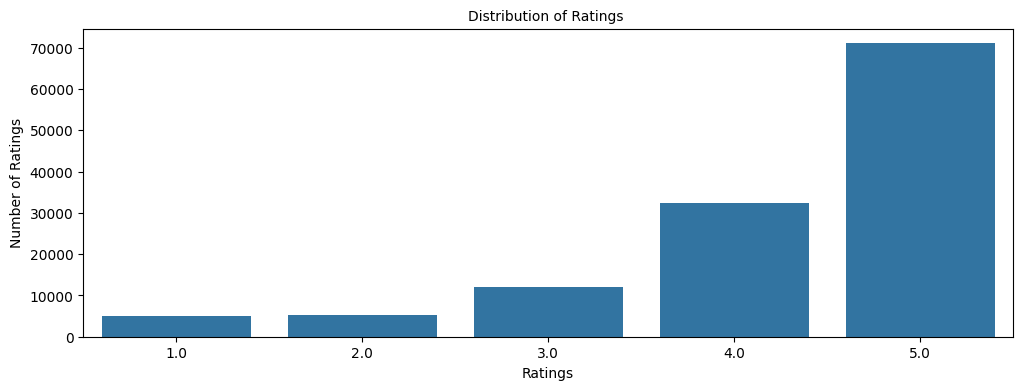

In [37]:
# Distribution of ratings
plt.figure(figsize = (12, 4))
sns.countplot(data=df, x='rating')

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

**Observations:**

- The rating 5 is the most common around 70K, followed by 4 ( around 34K) and then 3 (~15).
- The last two are 1 and 2.
- It is obvious the most frequent ratings are 5 and 4.
- The whole distribution is biased toward positive ratings.
- It shows people tend to give higher rates.


### **Checking the number of unique users and items in the dataset**

In [38]:
# Number of total rows in the data and number of unique user id and product id in the data

# Number of total rows in the data
num_total_rows = df_final.shape[0]

print("Number of total rows in the data:", num_total_rows)
print("Number of unique users:", df_final.user_id.nunique())
print("Number of unique items:", df_final.prod_id.nunique())

Number of total rows in the data: 65290
Number of unique users: 1540
Number of unique items: 5689


**Observations:**

- Number of total rows in the data: There are 65290 rows in the dataset. This indicates the total number of interactions or ratings recorded.

- Number of unique users: There are 1540 unique users in the dataset. Each user has provided one or more ratings for different products.

- Number of unique items (products): There are 5689 unique items (products) in the dataset. These are the products for which ratings have been provided by users.

- As per the number of unique users and items, there is a possibility of 1540 * 5689 = 8,761,060 ratings in the dataset. But we only have 65290 ratings, i.e., not every user has rated every item in the dataset. So, we can build a recommendation system to recommend items to users which they have not interacted with.

In [39]:
df_final.groupby(['user_id','prod_id']).count()

rating
user_id        prod_id           
A100UD67AHFODS B00004Z5M1       1
               B0001D3K8A       1
               B000233WJ6       1
               B0002KVQBA       1
               B0002SQ2P2       1
...                           ...
AZOK5STV85FBJ  B005PQTYHE       1
               B006MPRFJQ       1
               B00AANMVNQ       1
               B00B25P27S       1
               B00FB2XNCE       1

[65290 rows x 1 columns]

**Observations:**

- We can see the user_ids and his rated prod_id s.

In [40]:
df_final.groupby(['user_id','prod_id']).count()['rating'].sum()

65290

**Observation:**

The sum is equal to the total number of observations, which implies that there is only one interaction between an item and a user

In [41]:
df_final.prod_id.value_counts()

,count
prod_id,
B0088CJT4U,206
B003ES5ZUU,184
B000N99BBC,167
B007WTAJTO,164
B00829TIEK,149
...,...
B00368CDH6,5
B0036AZA6A,5
B0036E8V08,5


**Observations:**

- Product ID =B0088CJT4U, has been rated 206 times which is the most number of ratings it has been interacted by most users**( **206**).
- But still, there is a possibility of with 1540-206 = 1334 more interactions as we have 1540 unique users in our datasets. For those 1334 remaining users, we can build a recommendation system to predict who is most likely to interact with this item.
- Also, out of these 206 interactions, we need to consider the distribution of ratings as well to check whether this item is the most liked or most disliked item.

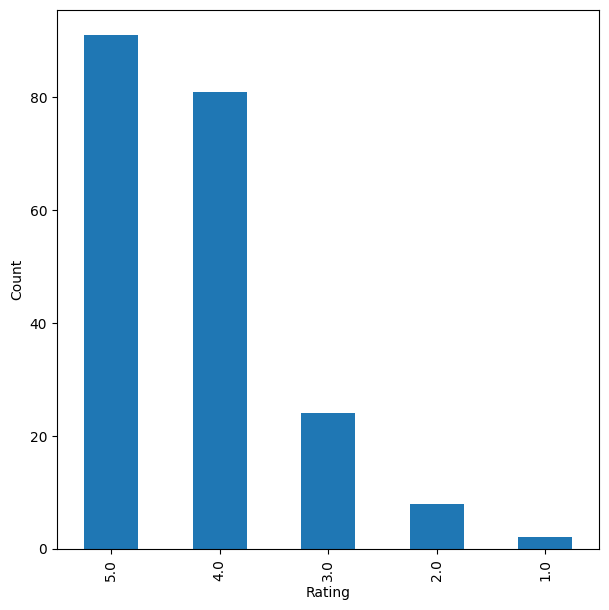

In [42]:
# Plotting distributions of ratings for the most interacted item
plt.figure(figsize=(7,7))
df_final[df_final['prod_id'] == 'B0088CJT4U']['rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

**Observations:**

- We can see that the majority of the ratings for this item are 5, followed by 4, and then 3.
- This implies that the item is liked by the majority of users as its rates are mostly 5,4 and 3.

### **Users with the most number of ratings**

In [43]:
# Top 10 users based on the number of ratings

# Group the data by 'user_id' and count the number of ratings for each user
user_ratings_count = df_final['user_id'].value_counts()

# Sort the users based on the number of ratings (descending order) and get the top 10 users
top_10_users = user_ratings_count.head(10)

print("Top 10 users based on the number of ratings:")
print(top_10_users)

Top 10 users based on the number of ratings:
user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A1UQBFCERIP7VJ    193
A22CW0ZHY3NJH8    193
AWPODHOB4GFWL     184
AGVWTYW0ULXHT     179
Name: count, dtype: int64


**Observations:**

- The top 10 user_id have the most number of ratings in the data set.
- The user with **user_id: ADLVFFE4VBT8** has interacted with the most number of items, i.e., **295** times.
- But still, there is a possibility of 5689-295 = 5394 more interactions as we have 5689 unique items in the dataset.

In [44]:
# Finding user-items interactions distribution
count_interactions = df_final.groupby('user_id').count()['prod_id']
count_interactions

,prod_id
user_id,
A100UD67AHFODS,53
A100WO06OQR8BQ,77
A105S56ODHGJEK,58
A105TOJ6LTVMBG,32
A10AFVU66A79Y1,47
...,...
AZBXKUH4AIW3X,22
AZCE11PSTCH1L,23
AZMY6E8B52L2T,105


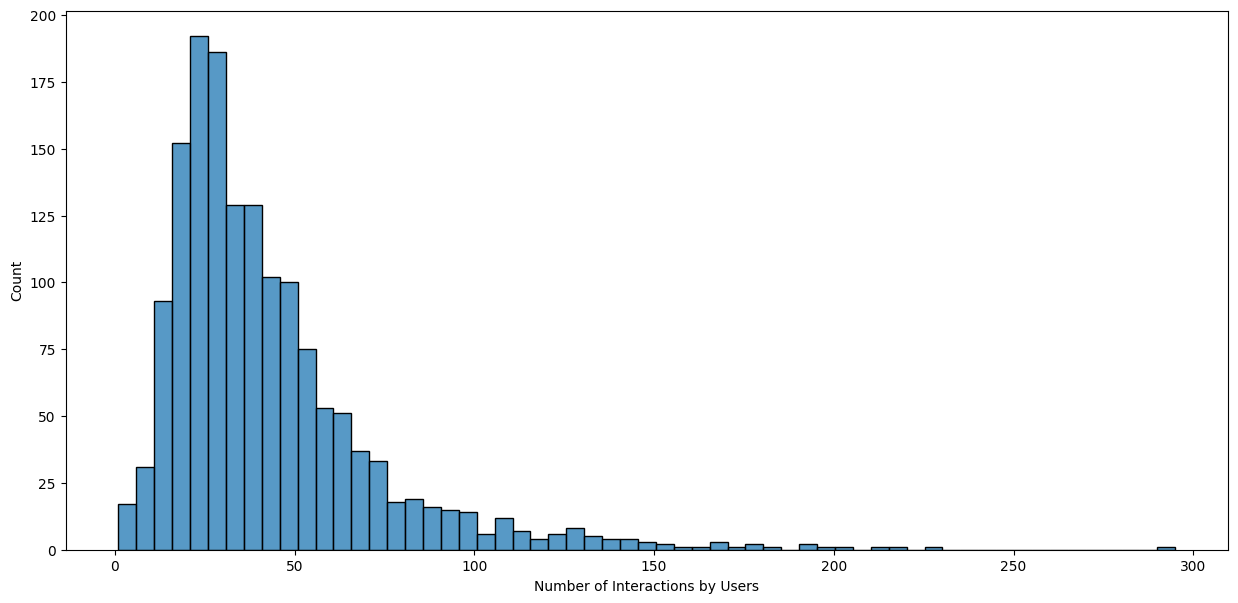

In [45]:
#Plotting user-item ineractions distribution

plt.figure(figsize=(15,7))
sns.histplot(count_interactions)
plt.xlabel('Number of Interactions by Users')
plt.show()

- The distribution is skewed to the right.
- Basically not many items have many ratings.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [46]:
# df_final is the DataFrame containing the data

# Calculate the average rating for each product

# Step 1: Convert the 'rating' column to numeric
df_final['rating'] = pd.to_numeric(df_final['rating'], errors='coerce')

# Step 2: Handle any non-numeric values
df_final.dropna(subset=['rating'], inplace=True)

# Step 3: Perform the aggregation operation
try:
    average_rating = df_final.groupby('prod_id')['rating'].mean()
    print(average_rating)
except Exception as e:
    print("Error occurred during aggregation:", e)

prod_id
1400501466    3.333333
1400532655    3.833333
1400599997    4.000000
9983891212    4.875000
B00000DM9W    5.000000
                ...   
B00L21HC7A    4.625000
B00L2442H0    4.916667
B00L26YDA4    4.384615
B00L3YHF6O    5.000000
B00LGQ6HL8    5.000000
Name: rating, Length: 5689, dtype: float64


In [47]:
# Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id').count()['rating']
count_rating

,rating
prod_id,
1400501466,6
1400532655,6
1400599997,5
9983891212,8
B00000DM9W,5
...,...
B00L21HC7A,16
B00L2442H0,12
B00L26YDA4,13


In [48]:
# Create a dataframe with calculated average and count of ratings
final_rating= pd.DataFrame({
    'avg_rating' : average_rating,
    'rating_count' : count_rating
})
#final_rating

# Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values(by='avg_rating', ascending=False)

# See the first five records of the "final_rating" dataset
final_rating.head()

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [50]:
#final_rating.rating_count.value_counts()

In [49]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions

def top_n_prods(data, n, min_interactions=100):
  # Finding products with minimum number of interactions
  recommendations = data[data.rating_count>min_interactions]

  # Sorting values with respect to average rating
  recommendations = recommendations.sort_values(by='avg_rating',ascending=False)

  #Return the top n of the recommendations data frame
  return recommendations.index[:n]

Now, let's create a function to find the **top n product** for a recommendation based on the average ratings of products. We can also add a **threshold for a minimum number of interactions** for a product to be considered for recommendation.

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [51]:
res = top_n_prods(final_rating,5,50)
res


Index(['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW'], dtype='object', name='prod_id')

In [52]:
list_of_rec_prods = []

for i in res:
  list_of_rec_prods.append(df_final[df_final['prod_id']==str(i)])

list_of_rec_prods

[                user_id     prod_id  rating
 2308466    ADLVFFE4VBT8  B001TH7GUU     5.0
 2308511  A1VLE2SH9J8WYS  B001TH7GUU     5.0
 2308543   AFNG8O2DXRCUV  B001TH7GUU     4.0
 2308548  A3QDMDSANPYGUX  B001TH7GUU     1.0
 2308549  A2GMZZ6TDYOHY7  B001TH7GUU     5.0
 ...                 ...         ...     ...
 2310538   A2SPV96SGOEO2  B001TH7GUU     5.0
 2310570  A2T3S3VTW65VO5  B001TH7GUU     5.0
 2310588   AOWF9T81XMX2S  B001TH7GUU     5.0
 2310594  A34C9AFFZOI45T  B001TH7GUU     5.0
 2310602   AI8EMB0HUC6Z5  B001TH7GUU     5.0
 
 [78 rows x 3 columns],
                 user_id     prod_id  rating
 3313486   AAXAKFQEAQPWC  B003ES5ZUU     3.0
 3313490  A3CW0ZLUO5X2B1  B003ES5ZUU     5.0
 3313605    ADLVFFE4VBT8  B003ES5ZUU     5.0
 3313635  A32O98PFC3OP7K  B003ES5ZUU     5.0
 3313779  A32QOZWIKQDNZX  B003ES5ZUU     5.0
 ...                 ...         ...     ...
 3323617  A1MFPAM9TTRTXN  B003ES5ZUU     5.0
 3323626  A3TCMJ6GKZJFBQ  B003ES5ZUU     3.0
 3323639  A2I2KPNJDQ9SL0  B00

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [53]:
res2 = top_n_prods(final_rating,5,100)
res2

Index(['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC'], dtype='object', name='prod_id')

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [54]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [55]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First create a default dictionary and map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    # Lopp through the user_id
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [56]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [57]:
#from sklearn.preprocessing import LabelEncoder
#data = df[['user_id','prod_id']].apply(LabelEncoder().fit_transform)

#data

In [58]:
#data['rating'] = df['rating']

#data

In [59]:
#df_rating = data.copy()

In [60]:
#average_rating = data.groupby('prod_id').mean()['rating']
#count_rating = data.groupby('prod_id').count()['rating']

#final_rating = pd.DataFrame (
  #  {'avg_rating' : average_rating,
  #  'rating_count' : count_rating
 #   }
#)

#final_rating

In [61]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0,5))

## Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.3, random_state=42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [62]:
# Declaring the similarity options
sim_options = {
    'name' : 'cosine',
    'user_based' : True
}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
algo_knn_user = KNNBasic(sim_options=sim_options, verbose=False)

# Fit the model on the training data
algo_knn_user.fit(trainset)


In [63]:
# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(algo_knn_user)

RMSE: 1.0250
Precision:  0.86
Recall:  0.783
F_1 score:  0.82


 **Observations**:

- RMSE (Root Mean Square Error): An RMSE of 1.0250 indicates that, on average, your system's predictions are about 1.025 units off from the actual ratings. Lower RMSE values are better, so there may be opportunities to enhance the model's accuracy.

- Precision: A precision of 0.86 means that 86% of the recommended items are relevant to the user's preferences. This is quite good but could be further optimized by fine-tuning the recommendation algorithm or considering additional features.

- Recall: A recall of 0.783 indicates that your system is capturing about 78.3% of all relevant items. Improving recall could involve incorporating more diverse user data or refining the similarity calculation method.

- F1 Score: The F1 score, which combines precision and recall, is 0.82. This is a solid score, but there may still be room to balance precision and recall more effectively depending on your specific goals.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [64]:
# Predicting rating for a sample user with an interacted product
algo_knn_user.predict("A3LDPF5FMB782Z","1400501466",r_ui=5, verbose= True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.00   {'actual_k': 4, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.0, details={'actual_k': 4, 'was_impossible': False})

**Observations:**
- The user A3LDPF5FMB782Z rated item 1400501466 as 5.00. The kNN algorithm predicted that the user would rate it as 3.00.

- The algorithm used 4 similar users/items (neighbors) in the prediction process.
- The prediction was possible and executed successfully.

- The predicted rating of 3.00 is lower than the actual rating of 5.00. This suggests that the algorithm might not have accurately captured the preferences or patterns of user A3LDPF5FMB782Z for item 1400501466.
- The fact that 4 similar users/items were used in the prediction indicates that the algorithm considered a reasonable number of neighbors but still produced a significantly different prediction compared to the actual rating.

Overall, this analysis highlights a discrepancy between the predicted and actual ratings, indicating a potential area for improvement in the recommendation algorithm's accuracy for this specific user-item pair.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [65]:
# Find unique user_id where prod_id is not equal to "1400501466"
unique_user_ids=df_final[df_final.prod_id != "1400501466"].user_id.unique()

# Check if the user 'A34BZM6S9L7QI4' is in the list
if 'A34BZM6S9L7QI4' in unique_user_ids:
    print("'A34BZM6S9L7QI4' is in the list of unique user IDs.")
else:
    print("'A34BZM6S9L7QI4' is not in the list of unique user IDs.")

'A34BZM6S9L7QI4' is in the list of unique user IDs.


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [67]:
# Predicting rating for a sample user with a non interacted product
algo_knn_user.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations:**

- The prediction of 4.29 suggests that if user A34BZM6S9L7QI4 were to interact with item 1400501466, the algorithm predicts they would likely rate it around 4.29.
- However, this prediction is marked as impossible due to not having enough similar users or items to make a reliable prediction.

- This scenario indicates a limitation of the kNN algorithm in this context. Without sufficient data or "neighbors," the algorithm struggles to make accurate predictions for user-item interactions.
  
- To improve predictions in such cases, the algorithm may need more data points or a different approach, such as incorporating additional features or using a different algorithm altogether.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [68]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [10, 20, 30, 40],  # The (max) number of neighbors to take into account
    'min_k': [1, 2, 3],  # The minimum number of neighbors for aggregation
    'sim_options': {
        'name': ['cosine', 'msd', 'pearson', 'pearson_baseline'],  # Similarity measures
        'user_based': [True]  # Whether to use user-based or item-based
    }
}

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3,n_jobs=-1 )


In [69]:
# Fitting the data
gs.fit(data)

In [71]:
# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9735497372661125
{'k': 40, 'min_k': 3, 'sim_options': {'name': 'cosine', 'user_based': True}}


**Observations:**

- The best RMSE score of approximately 0.972 ( versus 1.025 untuned hyper parameters) indicates that the recommendation system, using the specified parameters, was improved and has decent predictive accuracy.

- The combination of parameters that led to this best score (k=10, min_k=3, cosine similarity, user-based approach) suggests that the algorithm performs well with these settings.

Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [72]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {
    'name' : 'cosine',
    'user_based' : True
}

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized = KNNBasic(10, 3, sim_options=sim_options, random_state = 1, verbose = False)


In [73]:
# Training the algorithm on the train set
similarity_algo_optimized.fit(trainset)


In [74]:
# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(similarity_algo_optimized)

RMSE: 0.9653
Precision:  0.857
Recall:  0.806
F_1 score:  0.831


In [75]:
similarity_algo_optimized = KNNBasic(20, 3, sim_options=sim_options, random_state = 1, verbose = False)
similarity_algo_optimized.fit(trainset)
precision_recall_at_k(similarity_algo_optimized)

RMSE: 0.9636
Precision:  0.857
Recall:  0.806
F_1 score:  0.831


In [76]:
similarity_algo_optimized = KNNBasic(30, 3, sim_options=sim_options, random_state = 1, verbose = False)
similarity_algo_optimized.fit(trainset)
precision_recall_at_k(similarity_algo_optimized)

RMSE: 0.9634
Precision:  0.857
Recall:  0.806
F_1 score:  0.831


In [77]:
similarity_algo_optimized = KNNBasic(40, 3, sim_options=sim_options, random_state = 1, verbose = False)
similarity_algo_optimized.fit(trainset)
precision_recall_at_k(similarity_algo_optimized)

RMSE: 0.9633
Precision:  0.857
Recall:  0.806
F_1 score:  0.831


**Observations:**
- The RMSE decreased after tuning the hyperparameters (1.0250 -->0.9633)
- The F1 score increased from 0.82 to 0.83 after tuning the hyperparamteres!

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [78]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
similarity_algo_optimized.predict("A3LDPF5FMB782Z","1400501466", verbose= True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 3.00   {'actual_k': 4, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=3.0, details={'actual_k': 4, 'was_impossible': False})

**Observations:**

- It is same estimate as the original not-tuned method.
- The fact that the system considered 4 similar items (actual_k = 4) to make this prediction indicates that it relied on a small but relevant set of data points to estimate the user's preference. This can be seen as a localized recommendation approach.
- Since 'was_impossible' is False, it suggests that the prediction was successfully made using the available data and the algorithm didn't encounter any insurmountable issues or constraints.
- There is no improvment for this pair after tuning!

In [79]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
similarity_algo_optimized.predict("A34BZM6S9L7QI4","1400501466")

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations:**

- It seems the actual rating given by the user for this item is not available (r_ui=None). This could be due to various reasons such as the user not having rated the item yet or the rating being withheld for some other purpose.

- This is the estimated rating that the recommendation system predicted the user would give to the itemc is ~ 4.29.

- The reason for the prediction being marked as impossible is the lack of enough similar users (neighbors). This could be because the user 'A34BZM6S9L7QI4' is relatively unique in their preferences or hasn't interacted with enough items to establish strong patterns.

- Since the prediction was marked as impossible, it indicates that the recommendation system's confidence in this prediction is low. The estimated rating of 4.29 might not be very reliable due to the lack of sufficient data.

-  To improve predictions for this user and item combination, the recommendation system could benefit from gathering more data either from this user (if possible) or from users with similar tastes. Alternatively, using different techniques or algorithms that are more robust to sparse data could also help.

- There is no difference in the prediction of the baseline model and the tuned model for this particular user-item pair. Both models predicted the rating as 4.29.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [80]:
# 0 is the inner id of the above user
similarity_algo_optimized.get_neighbors(0,k=5)

[7, 12, 16, 17, 26]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [81]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

In [82]:
df_final

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0
...,...,...,...
7824423,A34BZM6S9L7QI4,B00LGQ6HL8,5.0
7824424,A1G650TTTHEAL5,B00LGQ6HL8,5.0
7824425,A25C2M3QF9G7OQ,B00LGQ6HL8,5.0
7824426,A1E1LEVQ9VQNK,B00LGQ6HL8,5.0


**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [83]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, similarity_algo_optimized)
recommendations

[('B000067RT6', 5),
 ('B00007EDZG', 5),
 ('B00009UTL1', 5),
 ('B000652M6Y', 5),
 ('B000BQ7GW8', 5)]

In [84]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(
    recommendations,
    columns = ['prod_id','predicted_rating']

)

,prod_id,predicted_rating
0,B000067RT6,5
1,B00007EDZG,5
2,B00009UTL1,5
3,B000652M6Y,5
4,B000BQ7GW8,5


- The algorith recommends that user (A3LDPF5FMB782Z) would love the above five products!

### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [85]:
# Declaring the similarity options
sim_options = {
    'name' : 'cosine',
    'user_based' : False
}

In [86]:
# KNN algorithm is used to find desired similar items. Use random_state=1
algo_knn_item = KNNBasic(sim_options=sim_options)

# Train the algorithm on the trainset, and predict ratings for the test set
algo_knn_item.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [87]:
# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(algo_knn_item)

RMSE: 1.0232
Precision:  0.835
Recall:  0.758
F_1 score:  0.795


**Observations:**

- We can observe that the baseline model has `RMSE=1.023` & `F_1 Score=0.79`on the test set.
- We can try to improve the performance number by using `GridSearchCV` to tune different hyperparameters of this algorithm.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [88]:
# Predicting rating for a sample user with an interacted product
algo_knn_item.predict("A3LDPF5FMB782Z","1400501466")

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.315789473684211, details={'actual_k': 19, 'was_impossible': False})

**Observations:**

- The estimated rating is 4.32, which is higher than the previous prediction of 3.0. This suggests that the system is more confident in predicting that the user would rate the item positively.
- Unlike the previous prediction, which considered 4 similar items, this prediction is based on 19 similar items. This indicates a broader analysis, likely leading to a more refined and accurate prediction.
- Similar to before, this indicates that the prediction was possible and no insurmountable issues were encountered.
- The higher estimated rating (4.32) in this prediction suggests that the system is more confident that the user would rate the item positively compared to the previous prediction (3.0).

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [89]:
# Predicting rating for a sample user with a non interacted product
algo_knn_item.predict("A34BZM6S9L7QI4","1400501466")

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations:**

The new result is essentially identical to the previous one, with no changes in the estimated rating or the reason for the prediction being marked as impossible.


### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [90]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k' : [10,20,30],
    'min_k' : [3,6,9],
    'sim_options' : {
        'name' : ['msd','cosine'],
        'user_based' : [False]
    }
}

In [91]:
# Performing 3-fold cross validation to tune the hyperparameters
grib_obj = GridSearchCV(KNNBasic, param_grid,measures=['rmse'],cv=3)

In [92]:
# Fitting the data
grib_obj.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

In [93]:
# Find the best RMSE score
grib_obj.best_score

# Find the combination of parameters that gave the best RMSE score
grib_obj.best_params


{'rmse': {'k': 20,
  'min_k': 6,
  'sim_options': {'name': 'msd', 'user_based': False}}}

- The best_param result with parameters k=30, min_k=6, using the MSD similarity metric, and an item-based collaborative filtering approach reflects a well-balanced and robust configuration for a recommendation system.

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [94]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {
    'name' : 'msd',
    'user_based' : False,
}

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(sim_options=sim_options,k=30,min_k=9)

In [95]:
# Training the algorithm on the trainset
similarity_algo_optimized_item.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [96]:
# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(similarity_algo_optimized_item)

RMSE: 0.9681
Precision:  0.836
Recall:  0.8
F_1 score:  0.818


**Observations:**

The results indicate a significant improvement after tuning hyperparameters for KNNBasic in the recommendation system.
- The RMSE decreased from 1.0232 to 0.9681, indicating a reduction in prediction error. Precision improved marginally from 0.835 to 0.836, while recall increased notably from 0.758 to 0.8.
- The F1 score also saw a substantial improvement from 0.795 to 0.818, suggesting a better balance between precision and recall.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [97]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
similarity_algo_optimized_item.predict("A3LDPF5FMB782Z","1400501466")

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.699444206926037, details={'actual_k': 19, 'was_impossible': False})

- The estimated rating is 4.70, which is even higher than both previous predictions (3.0 and 4.32). This suggests that the tuned Item-Item algorithm is more confident that the user would rate the item very positively.
- Similar to the previous prediction, this prediction is based on 19 similar items, indicating a comprehensive analysis.
- The prediction was possible without encountering any insurmountable issues.
- The higher estimated rating (4.70) in this tuned algorithm prediction indicates even greater confidence in predicting that the user would rate the item very positively compared to both past predictions.

In [98]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
similarity_algo_optimized_item.predict("A34BZM6S9L7QI4","1400501466")


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations:**

- The new result from the tuned item-item algorithm is nearly identical to the previous results in terms of the estimated rating and the reason for the prediction being marked as impossible.

- The tuned item-item algorithm, while showing consistency with previous results, still faces challenges related to sparse data and not having enough neighbors. Addressing these challenges through algorithmic exploration, feature engineering, data augmentation, and rigorous evaluation can lead to improved recommendation accuracy and user satisfaction.


### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [99]:
similarity_algo_optimized_item.get_neighbors(0,k=5)

[53, 67, 106, 151, 156]

- This time the neighbors have changed as we are using a different algorithm.

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [100]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, similarity_algo_optimized_item)
#recommendations

In [101]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.291403
1,1400599997,4.291403
2,9983891212,4.291403
3,B00000DM9W,4.291403
4,B00000J1V5,4.291403


- Algorithm gives the above item prdections for user specified above.

Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [102]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state=1)

# Training the algorithm on the trainset
svd.fit(trainset)

In [103]:
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.8989
Precision:  0.86
Recall:  0.797
F_1 score:  0.827


**Observations:**

- The baseline RMSE score for matrix factorization model outperformed both KNN algorithms (lowest so far)
- We observe that the **baseline F_1 score** for the matrix factorization model on the test set is higher in comparison to the F_1 score for the item-item similarity-based recommendation system and lower in comparison to the optimized user-user similarity-based recommendation system.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [104]:
# Making prediction
svd.predict("A3LDPF5FMB782Z","1400501466",r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.07   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.070652912318144, details={'was_impossible': False})

**Observations:**

- The matrix-factorization model predicts a rating of 4.07 for the user-item pair, which falls between the predictions of the original user-user algorithm (3.0) and the tuned Item-Item algorithm (4.70). This suggests that SVD is providing a moderately positive estimation for the user's rating.

- The ({'was_impossible': False}) indicates that the SVD algorithm was able to make the prediction without encountering any impossibility or constraint issues.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [105]:
# Making prediction
svd.predict("A34BZM6S9L7QI4","1400501466")

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.3949263041205775, details={'was_impossible': False})

**Observations:**

- The estimated rating of approximately 4.39 suggests that the algorithm believes the user is likely to rate the item positively.
- The estimated rating from the SVD algorithm for this user-item pair is slightly different from previous results, indicating variation in the prediction due to the different algorithm used.
- Unlike previous results where predictions were marked as impossible due to not enough neighbors, this prediction was not marked as impossible, suggesting that the SVD algorithm was able to make a prediction for this user-item pair.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [106]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30],
              'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]
}

# Performing 3-fold gridsearch cross-validation
gs_ = GridSearchCV(SVD,param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

In [107]:
# Fitting data
gs_.fit(data)

In [108]:
# Best RMSE score
print(gs_.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_.best_params)

0.8978814271076253
{'rmse': {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [109]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized = SVD(n_epochs=20,lr_all=0.01,reg_all=0.4,random_state=1)

# Train the algorithm on the trainset
svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 0.8908
Precision:  0.862
Recall:  0.801
F_1 score:  0.83


**Observations:**

- We observe that after tuning hyperparameters, the model performance has not improved by much. We can try other values for hyperparameters and see if we can get a better performance. However, here we will proceed with the existing model.


### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [110]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict("A3LDPF5FMB782Z","1400501466")

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.019121457463151, details={'was_impossible': False})

- HyperTuned matrix factorization algorithm predicts a rating of 4.01 for the user-item pair.
- This rating is close to the main algorithm's prediction (4.07) and falls within the range of predictions observed from different algorithms.

In [111]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict("A34BZM6S9L7QI4","1400501466")

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.108942506523911, details={'was_impossible': False})

- The optimized SVD algorithm successfully generated a prediction for the user 'A34BZM6S9L7QI4' regarding the item '1400501466', without being marked as impossible.
- The difference in the estimated rating compared to previous results indicates that optimization efforts have contributed to refining the prediction accuracy.
- Compared to the previous SVD result, the optimized SVD result shows a slight difference in the estimated rating, suggesting that optimization efforts have influenced the prediction.


### **Conclusion and Recommendations**

- In this case study, we built recommendation systems using four different algorithms. They are as follows:
  - Rank-based using averages
  - User-user similarity-based collaborative filtering
  - Item-item similarity-based collaborative filtering
  - Model-based (matrix factorization) collaborative filtering

- To demonstrate **"user-user similarity-based collaborative filtering", "item-item similarity-based collaborative filtering", and "model-based (matrix factorization) collaborative filtering"**, **surprise** library has been used. For these algorithms, **grid search cross-validation is used to find the optimal hyperparameters for the data**, and improve the performance of the model**.

- **For performance evaluation** of these models, **precision@k and recall@k** are used. Using these two metrics, the F_1 score is calculated for each working model.

- Collaborative Filtering searches for neighbors based on similarity of items (example) preferences and recommend items that those neighbors rate while Matrix factorization works by decomposing the user-item matrix into the product of two lower dimensionality rectangular matrices.

- User-User Similarity-based Algorithm:
        RMSE: 1.0250
        Precision: 0.86
        Recall: 0.783
        F1 score: 0.82

- Optimized User-User Similarity-based Algorithm:
        RMSE: 0.9633
        Precision: 0.857
        Recall: 0.806
        F1 score: 0.831

- Item-Item Similarity-based Algorithm:
        RMSE: 1.0232
        Precision: 0.835
        Recall: 0.758
        F1 score: 0.795

- Optimized Item-Item Similarity-based Algorithm:
        RMSE: 0.9681
        Precision: 0.836
        Recall: 0.8
        F1 score: 0.818

- Matrix Factorization model-based Algorithm:
        RMSE: 0.8989
        Precision: 0.86
        Recall: 0.797
        F1 score: 0.827

- Optimized Matrix Factorization model-based Algorithm:
        RMSE: 0.8908
        Precision: 0.862
        Recall: 0.801
        F1 score: 0.83

- RMSE (Root Mean Square Error): Lower is better, indicating better accuracy.
        The Optimized Matrix Factorization model-based Algorithm has the lowest RMSE, indicating the best accuracy among the models.

- Precision, Recall, and F1 Score:
        The Optimized Matrix Factorization model-based Algorithm and the Optimized User-User Similarity-based Algorithm generally perform the best across all three metrics. They strike a good balance between precision and recall, as reflected in their higher F1 scores.

- Optimized Matrix Factorization model-based Algorithm slightly outperforms the other models in terms of accuracy and balance between precision and recall.

- Tuning hyperparameters significantly improved the performance of both User-User and Item-Item KNN algorithms, particularly in recall, RMSE and F1 score metrics.

Recommendation:

- Based on the results and analysis, I recommend using the Optimized Matrix Factorization model-based Algorithm for the recommendation system. It offers the best balance between accuracy (low RMSE) and effectiveness in predicting user preferences (high precision, recall, and F1 score).

- Based on F1 score alone, the Optimized Matrix Factorization model-based Algorithm comes out on top, followed closely by the Optimized User-User Similarity-based Algorithm. These two algorithms exhibit the best balance between precision and recall, making them strong choices for recommendation systems where both accuracy and relevance of recommendations are crucial.

- We can try to further improve the performance of these models using hyperparameter tuning.

- We can also try to combine different recommendation techniques to build a more complex model like hybrid recommendation systems.

- It's recommended to consider predictions with a larger 'actual_k' value, as they indicate a more comprehensive analysis and are likely to be more accurate in predicting user preferences.

- Continuously refining the recommendation system's algorithms and data analysis techniques to increase the neighborhood size and improve prediction accuracy could lead to better user experiences and recommendations.

- It is also recommended to continue exploring hyperparameter tuning and possibly experimenting with different algorithms or ensemble methods to further enhance the recommendation system's performance. Additionally, conducting A/B testing with real users to validate the improvements and gather feedback would be beneficial in fine-tuning the system for optimal user satisfaction.

- It's recommended to continue monitoring and refining the tuned algorithm to ensure its effectiveness in making accurate predictions and improving user satisfaction.
